In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import totalsedimentload as tsl
from read_korean_data import *
from py_sedyield import *
#from matplotlib.patches import Polygon
import matplotlib.ticker as ticker
import re
import matplotlib.lines as mlines
import matplotlib.patches as patches
import matplotlib.lines as lines
%matplotlib inline

In [2]:
#plt.rc('font', family='Helvetica')
plt.rc("xtick",labelsize="large")
plt.rc("ytick",labelsize="large")
plt.rc("axes", labelsize="large")
plt.rc('axes', axisbelow=True)

In [3]:
# discharge data scraping
paths  = findExcelFiles()

# store the store in dict, station id as key
stations = {}

for path in paths:
    i = path.rfind("/")
    j = path.find("_", i)
    k = path.find("_", j+1)
    f = path[j+1:k]

    df = read_dischargeTimeSeries(path)
    sed = read_sediment_measurement(path)
    sed = sed[['Date', 'Q', 'C']]
    sed[['Q', 'C']] = sed[['Q', 'C']].apply(lambda x: pd.to_numeric(x, errors='coerce'))
    
    sed = sed.dropna(subset=["C"])
    stations[f] = {'dailyQ': df, 'measureC': sed}

In [4]:
# calc flow duration curve and sediment rating curve

for path in paths:
    i = path.rfind("/")
    j = path.find("_", i)
    k = path.find("_", j+1)
    f = path[j+1:k]

    df = tsl.raw_extract(path)
    semep = tsl.semep_procedure(df)
    Q = semep.Q
    Qt = semep.Qt
    q_qt_relation = trainLinear(Q, Qt)
    df['site'] = f
    
    stations[f].update({"fdc": flowDuration(stations[f]['dailyQ']),"src": q_qt_relation,
                        "semep":semep})

C:\Users\cyyang\Dropbox\work\dissertation\totalsedimentload.py:126: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ,names=["Date", "A", "h", "Q", "Temp", "C", "d50", "d65", "dss", "S"])
C:\ProgramData\Anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [5]:
attribute = load_attribute()

In [6]:
def flowDurationBins(flowDurationCurve):
    """Input: flow Duration Curve"""
    df = flowDurationCurve
    
    def extrapolate(dataframe):
        # find indexes of unknown 
        nanIndex = dataframe.Q[np.isnan(dataframe.Q)==True].index.tolist()
        try:
            if len(nanIndex)>0:
                for i in sorted(nanIndex,reverse=True):
                    indexlist = dataframe.index.tolist()
                    j = indexlist.index(i)
                    q1 = dataframe.iat[j+1,0]
                    q2 = dataframe.iat[j+2,0]
                    p1 = dataframe.iat[j+1,1]
                    p2 = dataframe.iat[j+2,1]
                    p0 = dataframe.iat[j,1]
                    q0 = q2 - (p2-p0)*(q2-q1)/(p2-p1)
                    dataframe.loc[i,'Q'] = q0
            return dataframe
        except:
            return dataframe    

    
    mid = [0.01,0.06,0.3,1,3.25,10,20,30,40,50,60,70,80,90,97.5]
    d = [0.02,0.08,0.4,1,3.5,10,10,10,10,10,10,10,10,10,5]
    a = np.empty(len(mid))
    a[:] = np.nan
    d_ = {'Q':a,'P':mid}
    df2 = pd.DataFrame(data=d_)
       
    result = pd.concat([df,df2]).drop_duplicates('P')
    result = result.sort_values('P')
    result2 = result.set_index('P')
    result2 = result2.interpolate(method='index')
    result2.loc[:,'P'] = result2.index
       
    result2 = result2.reset_index(drop=True)

    extrapolate(result2)
    
    selected = result2.loc[result2['P'].isin(mid)].reset_index(drop=True)
    selected.loc[:,'D'] = d
    return selected

In [7]:
import matplotlib.gridspec as gridspec

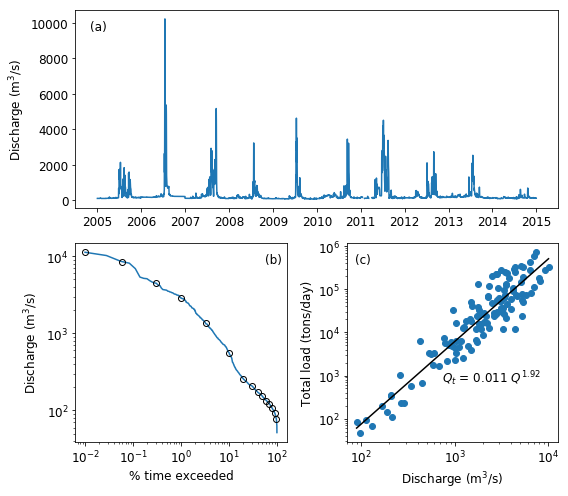

In [8]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(gs[0, :])
all_days = pd.date_range(stations['H1']['dailyQ'].index.min(), stations['H1']['dailyQ'].index.max(), freq='D')
#stations['H1']['dailyQ'] = selected.reindex(all_days)
lns1 = ax1.plot(stations['H1']['dailyQ']['date'], stations['H1']['dailyQ']['Q'], label='$Q$')
ax1.set(ylabel='Discharge (m$^3$/s)')

ax3 = fig.add_subplot(gs[1,0])

df = flowDurationBins(stations['H1']['fdc'])
P = np.append(df.loc[0, 'P'], stations['H1']['fdc'].P)
Q = np.append(df.loc[0, 'Q'], stations['H1']['fdc'].Q)
ax3.plot(P, Q)
ax3.plot(df.P, df.Q, 'o', color='none', mec='k')
ax3.set(xscale='log', yscale='log', xlabel='% time exceeded', ylabel='Discharge (m$^3$/s)')

ax4 = fig.add_subplot(gs[1,1])
ax4.plot(stations['H1']['semep']['Q'], stations['H1']['semep']['Qt'], 'o')
ax4.set(xscale='log', yscale='log', xlabel='Discharge (m$^3$/s)', ylabel='Total load (tons/day)')
a, b = get_regression_params(stations['H1']['src'])
q_plot = np.array([stations['H1']['semep']['Q'].min(), stations['H1']['semep']['Q'].max()])
ax4.plot(q_plot, a * q_plot**b, 'k-')

ax1.annotate('(a)', (0.03, 0.9), xycoords='axes fraction', fontsize='large')
ax3.annotate('(b)', (0.9, 0.9), xycoords='axes fraction', fontsize='large')
ax4.annotate('(c)', (0.04, 0.9), xycoords='axes fraction', fontsize='large')
ax4.annotate('$Q_t$ = 0.011 $Q^{1.92}$', (0.45, 0.3), xycoords='axes fraction', fontsize='large')
fig.tight_layout()
#fig.savefig('fdc.pdf', format='pdf', dpi=300)

# Flow vs area

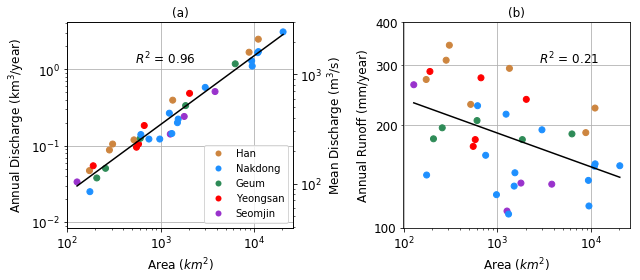

In [13]:
annual_Q = []
for station in stations.keys():
    length = len(stations[station]['fdc'])/len(stations[station]['dailyQ'])
    df = flowDurationBins(stations[station]["fdc"])
    df['QxD'] = df["Q"] * df['D']
    Qyield = df['QxD'].sum()*86400
    Qmean = df["Q"].mean()
    annual_Q.append((station, Qyield, length, Qmean))
df = pd.DataFrame(annual_Q, columns=["site","Qyield", "flowLen", 'Qmean']).set_index('site')

df = attribute.join(df)
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4))
ax3 = ax1.twinx()

df = df.sort_values("Area")
x = df["Area"]
y = df["Qyield"]/1000000000
df['Runoff'] = df['Qyield']/(df['Area']*1000)


m = trainLinear(x, y)
a, b = get_regression_params(m)


syyModel = trainLinear(df["Qyield"], df["Qmean"])
a2, b2 = get_regression_params(syyModel)

symodel = trainLinear(df['Area'], df["Qyield"]/(df['Area']*1000000))
a3, b3 = get_regression_params(symodel)


colors = {'H': '#CD853F', 'N': '#1E90FF', 'G':'#2E8B57', 'Y':'#FF0000', 'S':'#9932CC'}

ax1.scatter(df["Area"], df["Qyield"]/1000000000, color=[colors[x] for x in df.index.str[0]])
ax3.plot(df["Area"], a2*df["Qyield"]**b2, '.', mfc='none', mec='none')
ax1.plot(x, a*x**b, 'k-')

#ax.set_title("(a)")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("Area $(km^2)$")
ax1.annotate(r"$R^2$ = {:.{prec}f}".format(m.rsquared, prec=2), xy=(0.3, 0.8), xycoords="axes fraction",
             fontsize="large")

#ax1.legend()

ax3.set_yscale("log")
ax3.set_ylabel(r'Mean Discharge (m$^3$/s)')
ax3.set_xlabel("Mean annaul flow (cms)")
#ax2.set_title("(b)")
ax1.set_ylabel(r"Annual Discharge (km$^3$/year)")
ax1.grid()
ax1.set_title("(a)")
ax2.scatter(df['Area'], (df["Qyield"]/(df['Area']*1000000))*1000, color=[colors[x] for x in df.index.str[0]])
ax2.plot(df['Area'], (a3*df['Area']**b3)*1000, 'k-')

ax2.annotate(r"$R^2$ = {:.{prec}f}".format(symodel.rsquared, prec=2), xy=(0.6, 0.8), xycoords="axes fraction",
             fontsize="large")

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylabel(r'Annual Runoff (mm/year)')
ax2.set_xlabel("Area $(km^2)$")
ax2.set_title("(b)")
ax2.set_ylim([100,400])
ax2.yaxis.set_minor_formatter(ticker.FuncFormatter(myLogFormat))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
ax2.grid(axis='y', which='both')
ax2.grid(axis='x', which='major')

han = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["H"], label='Han')
nakdong = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["N"], label='Nakdong')
geum = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["G"], label='Geum')
yeongsan = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["Y"], label='Yeongsan')
seomjin = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["S"], label='Seomjin')


handles = [han,nakdong, geum, yeongsan, seomjin]
labels = [h.get_label() for h in handles]
ax1.legend(handles=handles, labels=labels, numpoints=1, loc='lower right')


fig.tight_layout()
#fig.savefig("Area_Qyield.pdf", format="pdf")

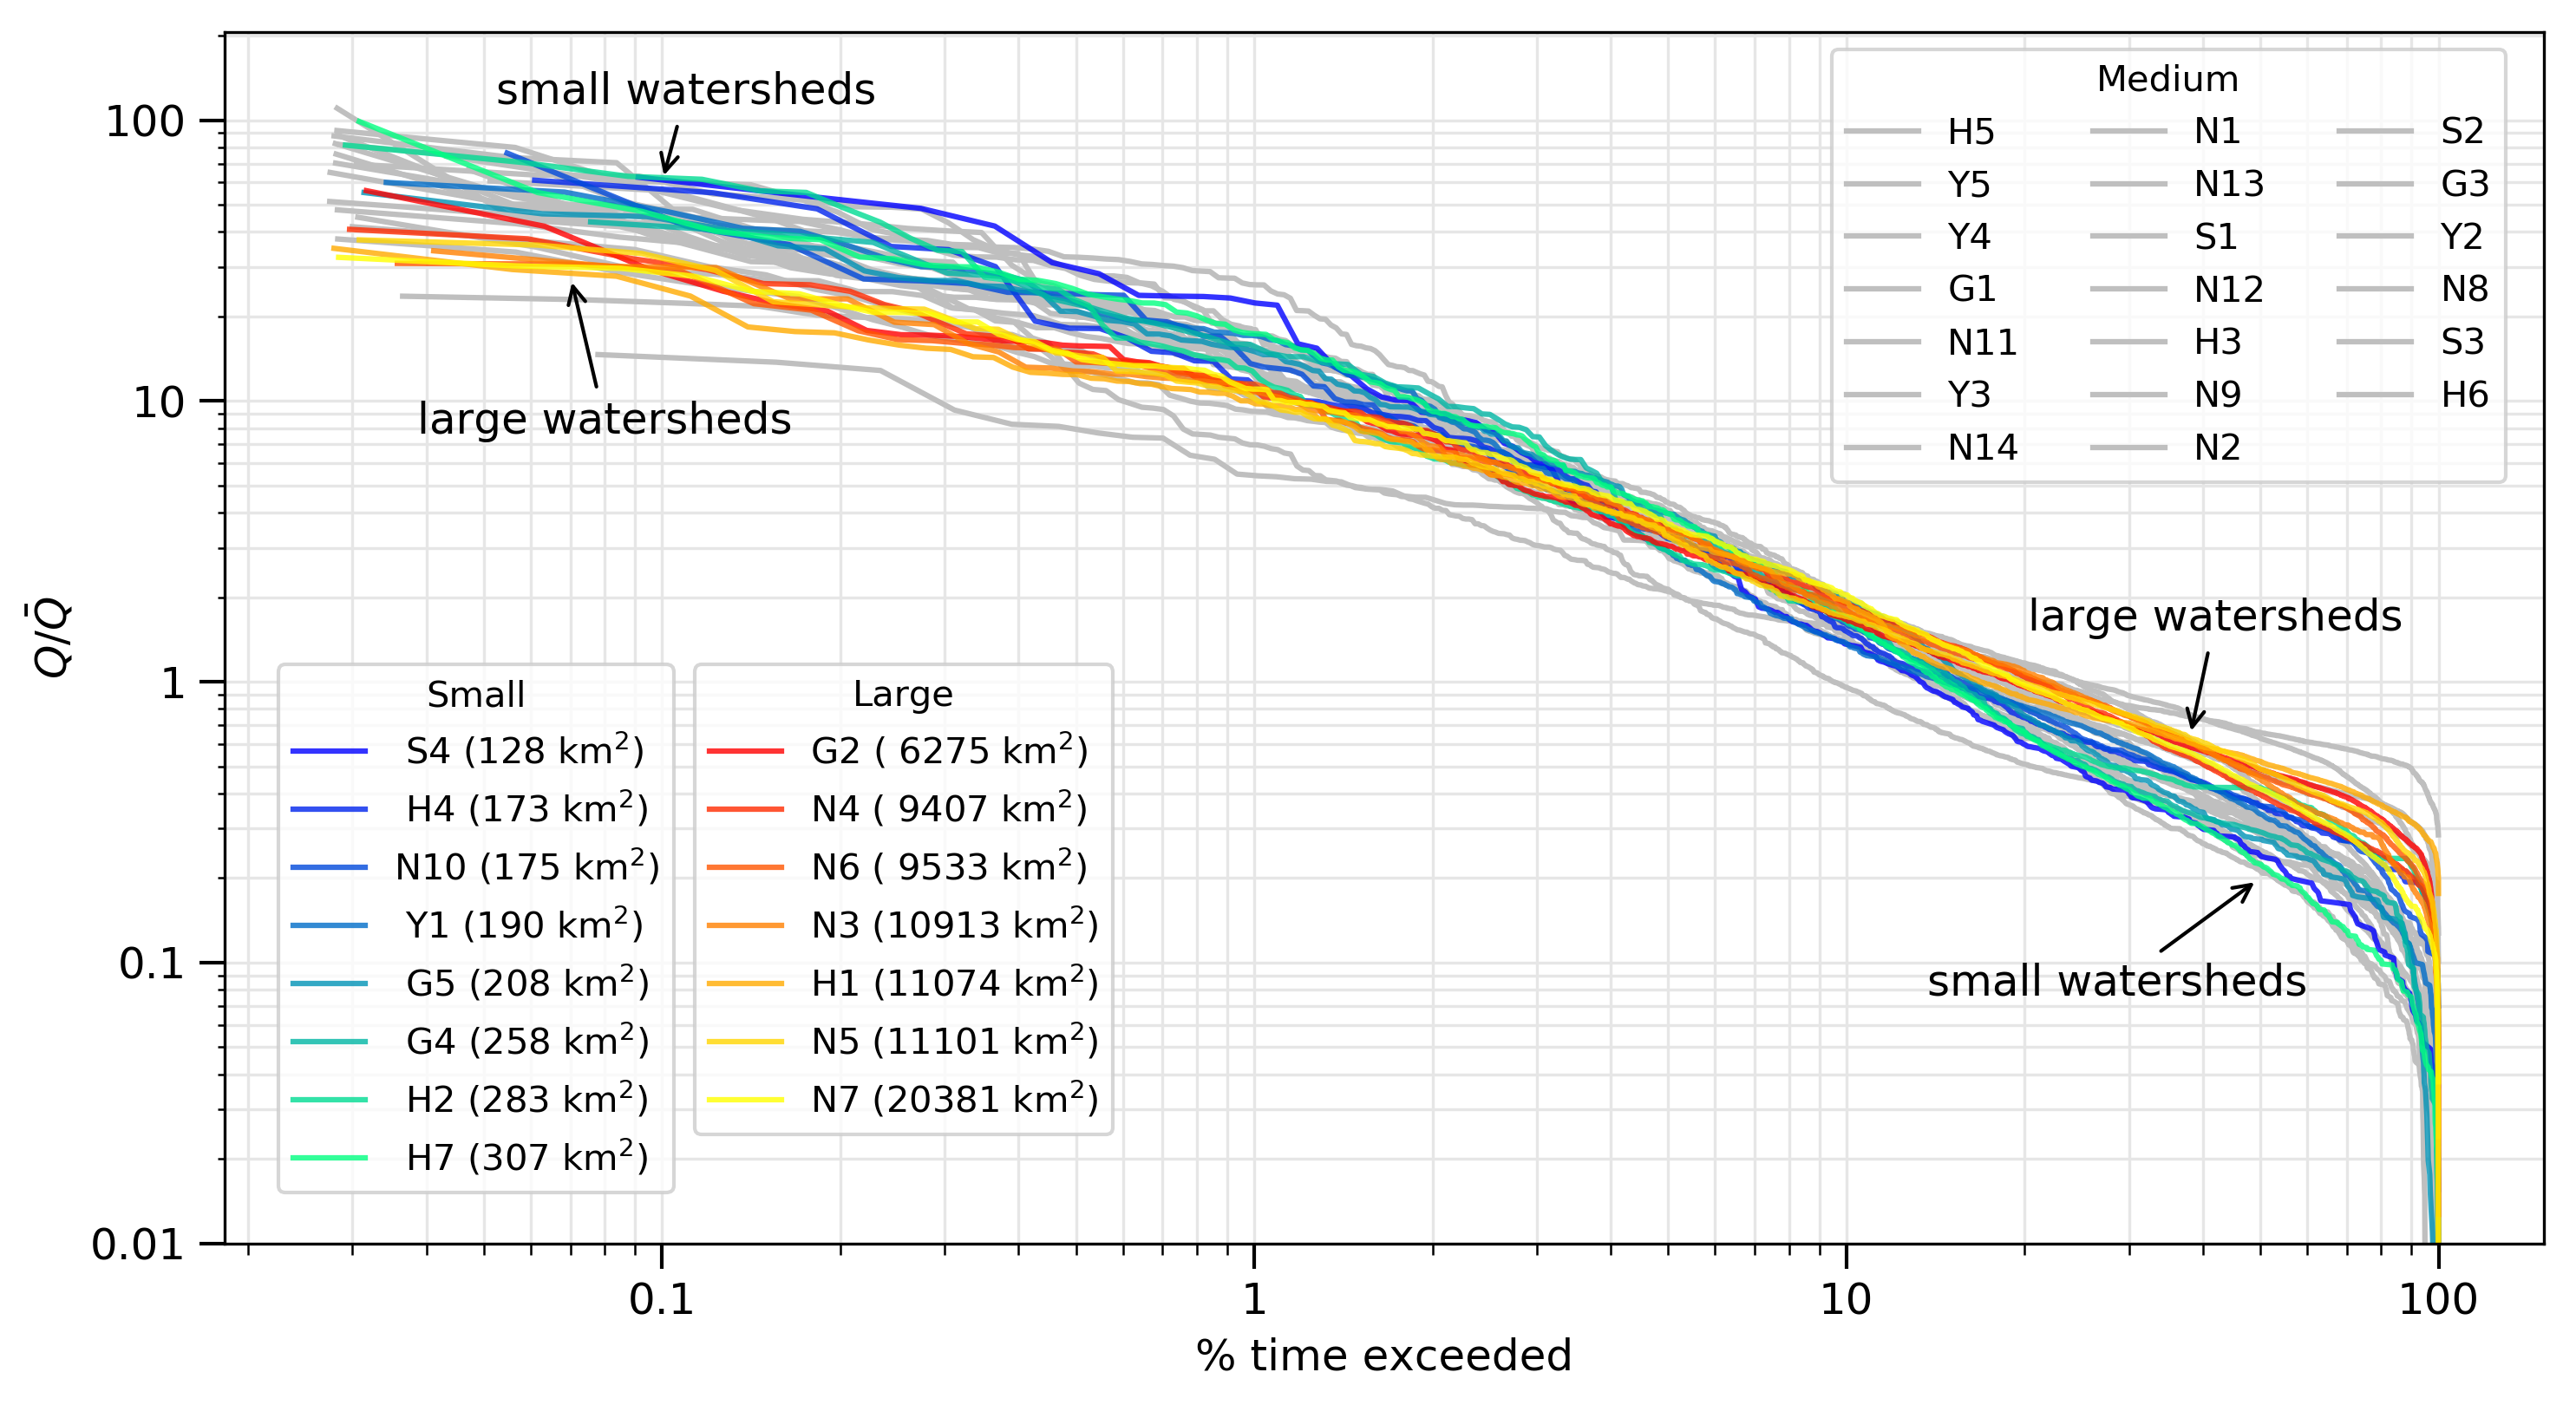

In [14]:
fig, ax = plt.subplots(figsize=(10,5.5),dpi=300)

lw = 0.6
colors = {'H': '#CD853F', 'N': '#1E90FF', 'G':'#2E8B57', 'Y':'#FF0000', 'S':'#9932CC'}

station_below_dam = ["H3", "H6", "N8", "N13", "Y5", "S1", "S2", "S3"]
small_watershed = attribute[(attribute["Area"] < 500) & ~(attribute.index.isin(station_below_dam))].sort_values("Area").index
large_watershed = attribute[(attribute["Area"] > 5000) & ~(attribute.index.isin(station_below_dam))].sort_values("Area").index
rest = attribute[~attribute.index.isin(small_watershed.append(large_watershed))].sort_values("Area").index


def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

for station in rest: 
    df = stations[station]['fdc']
    Qins = flowDurationBins(df)
    Qins = np.interp(1, df.P, df.Q)
    Q_mean = stations[station]['fdc'].Q.mean()
        
    ax.plot(df.P, df['Q']/Q_mean , color='0.75', label=station)

color_index = np.linspace(0,1,len(small_watershed))

for i, station in zip(color_index, small_watershed):
    df = stations[station]['fdc']
    Qins = flowDurationBins(df)
    Qins = np.interp(1, df.P, df.Q)
    Q_mean = stations[station]['fdc'].Q.mean()
    ax.plot(df.P, df['Q']/Q_mean, color=plt.cm.winter(i), label='{:>3s} ({:>3} km$^2$)'.format(station, str(int(round(attribute.loc[station, 'Area'])))), alpha=0.8)
    
                         
color_index = np.linspace(0,1,len(large_watershed))
for i, station in zip(color_index, large_watershed):
    df = stations[station]['fdc']
    Qins = flowDurationBins(df)
    Qins = np.interp(1, df.P, df.Q)
    Q_mean = stations[station]['fdc'].Q.mean()
        
    ax.plot(df.P, df['Q']/Q_mean, color=plt.cm.autumn(i), label='{:>2} ({:>5} km$^2$)'.format(station, str(int(round(attribute.loc[station, 'Area'])))), alpha=0.8)
handles, labels = ax.get_legend_handles_labels()


fig.legend(handles[:len(rest)], labels[:len(rest)], bbox_to_anchor=[0.97, 0.96],loc="upper right", ncol=3, title='Medium')
fig.legend(handles[len(rest):len(rest)+len(small_watershed)], labels[len(rest):len(rest)+len(small_watershed)],
           bbox_to_anchor=[0.1, 0.53], loc="upper left", ncol=1, title='Small')

fig.legend(handles[len(rest)+len(small_watershed):], labels[len(rest)+len(small_watershed):],
           bbox_to_anchor=[0.26, 0.53], loc="upper left", ncol=1, title='Large')

ax.annotate("small watersheds", xy=(0.1, 60),  xycoords='data',
            xytext=(0.11, 150), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='top', fontsize="large")
ax.annotate("large watersheds", xy=(0.07, 28),  xycoords='data',
            xytext=(0.08, 10), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='top', fontsize="large")

ax.annotate("large watersheds", xy=(38, 0.63),  xycoords='data',
            xytext=(42, 2), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='top', fontsize="large")

ax.annotate("small watersheds", xy=(50, 0.2),  xycoords='data',
            xytext=(60, 0.1), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            horizontalalignment='right', verticalalignment='top', fontsize="large")




ax.set_xscale('log')
ax.set_yscale('log')
        #ax2 = ax.twiny()
        #ax2.plot(stations[station]['dailyQ']['date'], stations[station]['dailyQ']['Q'])
        #ax.grid(which='both')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
ax.tick_params(axis='both', length=7, width=1)
ax.tick_params(axis='x', length=3, which="minor")
ax.grid(which='both', color="0.9")
ax.set_axisbelow(True)
ax.set_ylabel(r"$Q/\bar{Q}$")
ax.set_xlabel("% time exceeded")
ax.set_ylim(ymin=0.01)
fig.tight_layout()
#fig.savefig("fdc_small_and_large_watershed.pdf", format="pdf")


In [15]:
def findQQ():
    Q_exceed = {}

    for site in stations.keys():
        df = stations[site]['fdc']
        Q_mean = stations[site]['fdc'].Q.mean()

        Qins = np.interp([0.1, 1, 10, 75], df.P, df['Q']/Q_mean)
        Q_exceed[site] = Qins

    Q_exceed = pd.DataFrame(Q_exceed).T
    Q_exceed.columns = ["Q0.1", "Q1", "Q10", "Q50"]
    return attribute.join(Q_exceed)

0.47356199234721175
0.25643011247709957
0.2766765008026697


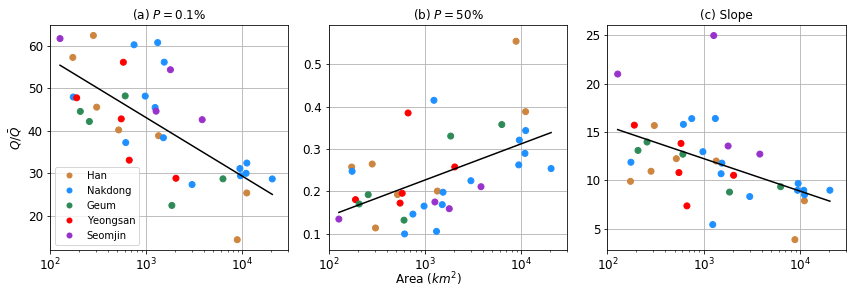

In [16]:
df = findQQ()

fig, (ax1,ax3,ax2) = plt.subplots(1,3, figsize=(12,4))


for ax in [ax1, ax2, ax3]:
    #ax.autoscale(enable=False)
    ax.grid()
    ax.set(xscale='log', xlim=(100, 30000))
    


df = df.sort_values(by='Area')


def plot_regression(ax, y):
    m = trainLinear(df['Area'], y)
    coef1, coef2 = get_regression_params(m)
    ax.plot(df.Area, np.log(coef1*df.Area**coef2), 'k-')
    print(m.rsquared)
ax1.scatter(df["Area"], df["Q0.1"], color=[colors[x] for x in df.index.str[0]], label='Q0.1')
plot_regression(ax1, np.e**df['Q0.1'])



ax2.scatter(df["Area"], np.abs(df['Q10'] - df['Q1']), color=[colors[x] for x in df.index.str[0]], label='Q1')
plot_regression(ax2, np.e**np.abs(df['Q10'] - df['Q1']))

ax3.scatter(df["Area"], df["Q50"], color=[colors[x] for x in df.index.str[0]], label='Q50')
plot_regression(ax3, np.e**df['Q50'])
ax1.set_title("(a) $P =0.1\%$")
ax2.set_title("(c) Slope")
ax3.set_title("(b) $P = 50\%$")

han = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["H"], label='Han')
nakdong = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["N"], label='Nakdong')
geum = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["G"], label='Geum')
yeongsan = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["Y"], label='Yeongsan')
seomjin = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["S"], label='Seomjin')


handles = [han,nakdong, geum, yeongsan, seomjin]
labels = [h.get_label() for h in handles]
ax1.legend(handles=handles, labels=labels, numpoints=1, loc=3)

for ax in [ax1, ax2, ax3]:
    ax.set_axisbelow(True)
ax1.set_ylabel(r'$Q/\bar{Q}$')
#
fig.text(0.5, 0.001, 'Area ($km^2$)', ha='center', fontsize='large')

fig.tight_layout()
#fig.savefig('Qins_vs_area.pdf', format="pdf", dpi=300, bbox_inches='tight')

# Sediment Rating Curve

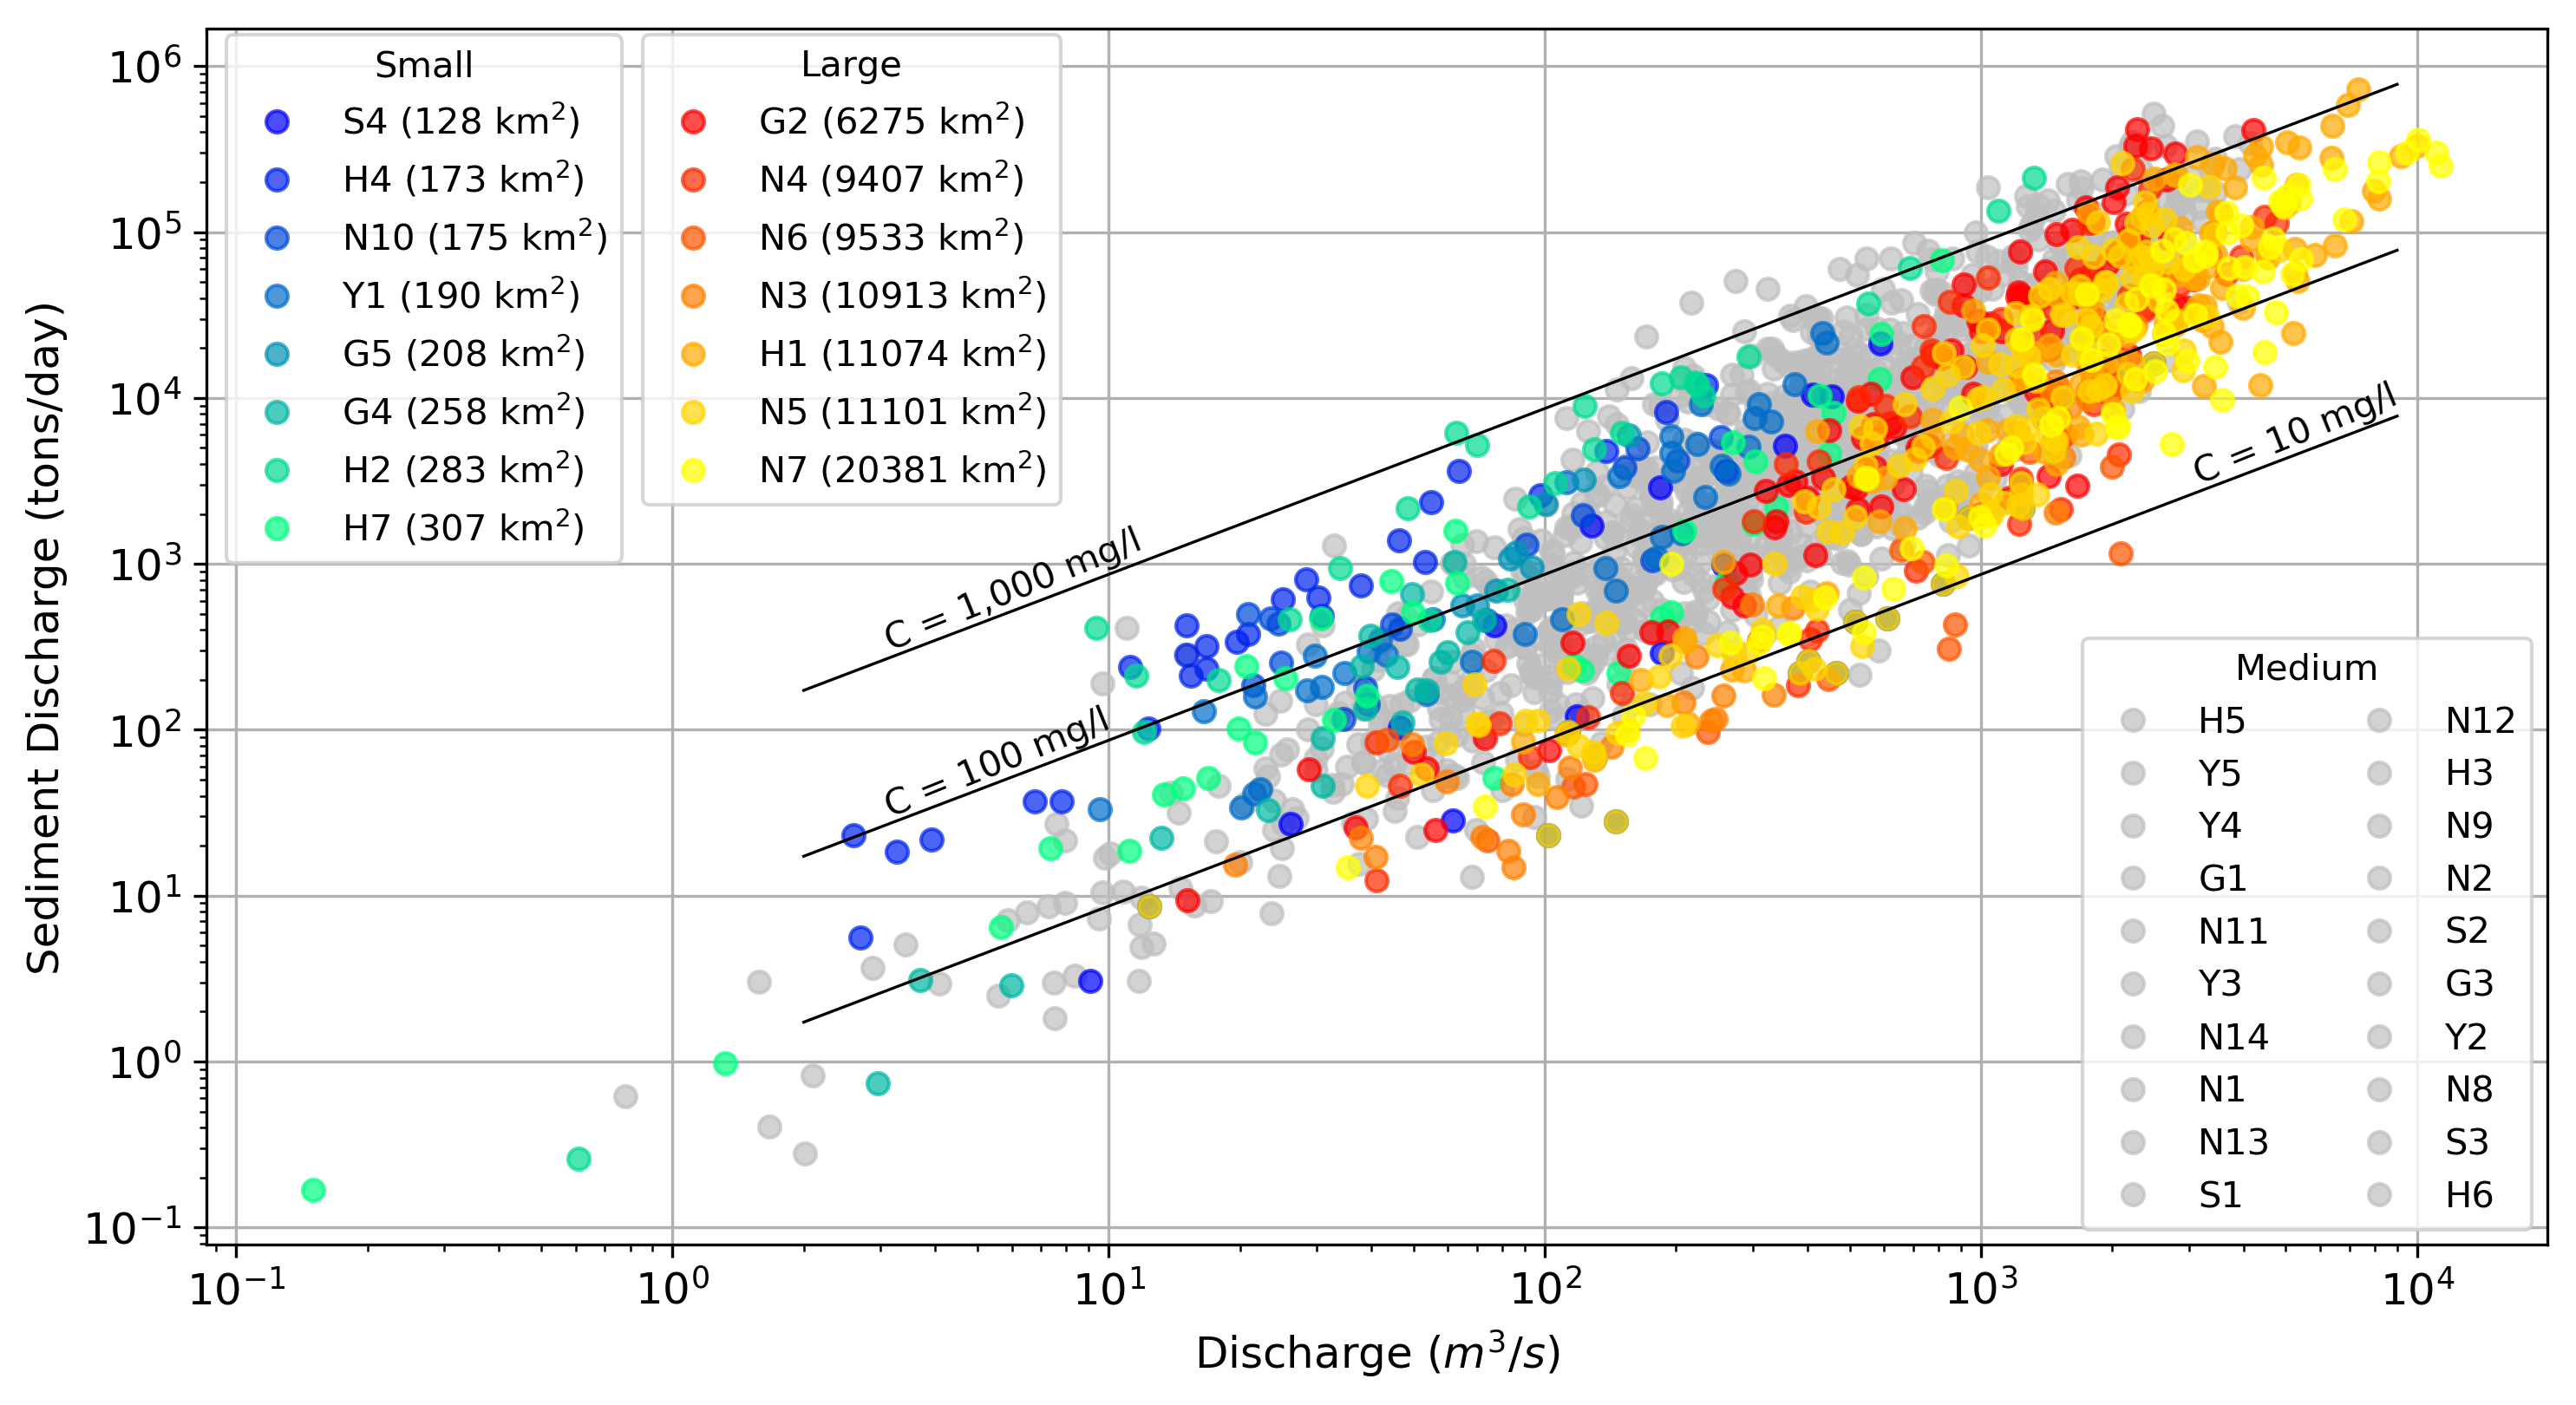

In [18]:
fig, ax = plt.subplots(figsize=(10,5.5), dpi=300)


for station in rest:
    df = stations[station]["semep"]
    ax.plot(df.Q, df.Qt, 'o', color='0.75', label=station, alpha=0.7)

color_idx = np.linspace(0, 1, len(small_watershed))
for i, station in zip(color_idx, small_watershed):
    df = stations[station]["semep"]
    src = stations[station]["src"]
    Q_mean = stations[station]['fdc'].Q.mean()
    #a = np.e**src.params[0]
    #b = src.params[1]
    #Q = df.Q.sort_values()
    ax.plot(df.Q, df.Qt, 'o', color=plt.cm.winter(i), label=station+ ' (' + str(int(round(attribute.loc[station, 'Area']))) + ' km$^2$)', alpha=0.7)

    
color_idx = np.linspace(0, 1, len(large_watershed))
for i, station in zip(color_idx, large_watershed):
    df = stations[station]["semep"]
    Q_mean = stations[station]['fdc'].Q.mean()
    ax.plot(df.Q, df.Qt, 'o', color=plt.cm.autumn(i), label=station + ' (' + str(int(round(attribute.loc[station, 'Area']))) + ' km$^2$)', alpha=0.7)
    

handles, labels = ax.get_legend_handles_labels()


x = np.linspace(2, 9000, 10)
ax.plot(x, 0.0864*1000*x, 'k-', linewidth=0.8)
ax.plot(x, 0.0864*100*x, 'k-', linewidth=0.8)
ax.plot(x, 0.0864*10*x, 'k-', linewidth=0.8)
ax.annotate('C = 1,000 mg/l', (3, 1200), rotation=22)
ax.annotate('C = 100 mg/l', (3, 100), rotation=22)
ax.annotate('C = 10 mg/l', (3000, 9000), rotation=22)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Discharge ($m^3/s$)")
ax.set_ylabel("Sediment Discharge (tons/day)")
ax.grid()
fig.legend(handles[:len(rest)], labels[:len(rest)], bbox_to_anchor=[0.98, 0.11],loc="lower right", ncol=2, title='Medium')
fig.legend(handles[len(rest):len(rest)+len(small_watershed)], labels[len(rest):len(rest)+len(small_watershed)],
           bbox_to_anchor=[0.08, 0.97], loc="upper left", ncol=1, title='Small')

fig.legend(handles[len(rest)+len(small_watershed):], labels[len(rest)+len(small_watershed):],
           bbox_to_anchor=[0.24, 0.97], loc="upper left", ncol=1, title='Large')

fig.tight_layout()
#fig.savefig("SRC_GroupByArea.pdf", format="pdf", dpi=300)

In [19]:
def src_coefficient():
    src = pd.DataFrame(columns = ["a", "b", "Rsquared"])
    len_sed_record = []
    for site in stations.keys():
        m = stations[site]["src"]
        src.loc[site] = pd.Series((np.e**m.params[0], m.params[1], m.rsquared), index=["a", "b", "Rsquared"])
        l = len(stations[site]['measureC'])
        n_year = len(stations[site]['measureC']['Date'].dt.year.unique())
        len_sed_record.append((site, l, n_year))       
    src = attribute.join(src)[["Area", "a", "b", "Rsquared"]].sort_values("Area")
    src = src.join(pd.DataFrame(len_sed_record,columns=['site','length','nyear']).set_index('site'))
    return src

In [20]:
src = src_coefficient()

def check_quality(df):
    return np.where(((df.nyear > 2) & (df.Rsquared > 0.7)), 'good', np.where(df.Rsquared < 0.7, 'poor', 'short'))


np.vectorize(colors.get)(src.index.str[0])
#check_quality(src).apply(colors)

array(['#9932CC', '#CD853F', '#1E90FF', '#FF0000', '#2E8B57', '#2E8B57',
       '#CD853F', '#CD853F', '#CD853F', '#FF0000', '#FF0000', '#2E8B57',
       '#1E90FF', '#FF0000', '#1E90FF', '#1E90FF', '#1E90FF', '#9932CC',
       '#1E90FF', '#CD853F', '#1E90FF', '#1E90FF', '#9932CC', '#2E8B57',
       '#FF0000', '#1E90FF', '#9932CC', '#2E8B57', '#CD853F', '#1E90FF',
       '#1E90FF', '#1E90FF', '#CD853F', '#1E90FF', '#1E90FF'], dtype='<U7')

0.4118795830760674


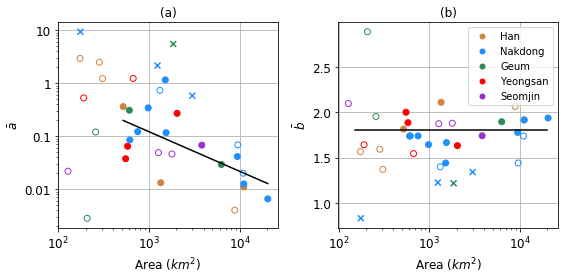

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))


def plot_regression(ax, x, y):
    m = trainLinear(x, y)
    coef1, coef2 = get_regression_params(m)
    ax.plot(x, coef1*x**coef2, 'k-')
    print(m.rsquared)



src = src_coefficient()
good_data = src[(src['Rsquared'] > 0.7) & (src['nyear'] > 2)]
short_data = src[(src['nyear'] <= 2) & (src['Rsquared'] > 0.7)]
poor_r = src[src['Rsquared'] <= 0.7]


ax1.scatter(good_data['Area'], good_data['a'], color=[colors[x] for x in good_data.index.str[0]])
ax1.scatter(short_data['Area'], short_data['a'], facecolor='none', 
            edgecolors=[colors[x] for x in short_data.index.str[0]])
ax1.scatter(poor_r['Area'], poor_r['a'], marker='x', color=[colors[x] for x in poor_r.index.str[0]])
ax1.set_ylabel(r'$\bar{a}$')
ax1.set_xlabel('Area ($km^2$)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title("(a)")
ax1.set_xlim((99.132269285392965, 26264.424798119511))
ax1.set_ylim((0.0018854546190914428, 13.969220738039738))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
ax1.grid()

plot_regression(ax1, good_data['Area'], good_data['a'])



ax2.scatter(good_data['Area'], good_data['b'], color=[colors[x] for x in good_data.index.str[0]])
ax2.scatter(short_data['Area'], short_data['b'], facecolor='none', 
            edgecolors=[colors[x] for x in short_data.index.str[0]])
ax2.scatter(poor_r['Area'], poor_r['b'], marker='x', color=[colors[x] for x in poor_r.index.str[0]])
ax2.set_xscale('log')
ax2.set_ylabel(r'$\bar{b}$')
ax2.set_xlabel('Area ($km^2$)')
ax2.set_title("(b)")
ax2.set_xlim((99.132269285392965, 26264.424798119511))
ax2.set_ylim((0.72879636854539298, 2.9919397796794747))
ax2.plot([150, 20000], [1.8, 1.8], 'k-')

han = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["H"], label='Han')
nakdong = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["N"], label='Nakdong')
geum = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["G"], label='Geum')
yeongsan = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["Y"], label='Yeongsan')
seomjin = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["S"], label='Seomjin')


handles = [han,nakdong, geum, yeongsan, seomjin]
labels = [h.get_label() for h in handles]
ax2.legend(handles=handles, labels=labels, numpoints=1, loc='best')

ax2.grid()
fig.tight_layout()
#ax2.set_yscale('log')
#fig.savefig('src_vs_area.pdf', format='pdf', dpi=300)

In [22]:
def cal_sediment_yield(verbose=False):
    ssy_summary = []

    for site in stations.keys():
        fdc = stations[site]['fdc']
        src = stations[site]['src']

        df = FDSRC(fdc,src)
        SY = df.QtXD.sum()*365.25
        ssy_summary.append((site, SY))
    df = attribute.join(pd.DataFrame(ssy_summary, columns=["site", "SY"]).set_index("site"))
    df["SD"] = df["SY"]/df["Area"]
    df = df.sort_values("Area")
    m = trainLinear(df["Area"], df["SD"])
    a, b = get_regression_params(m)
    if verbose == True:
        print(a, b)
        print(m.rsquared)
    return df

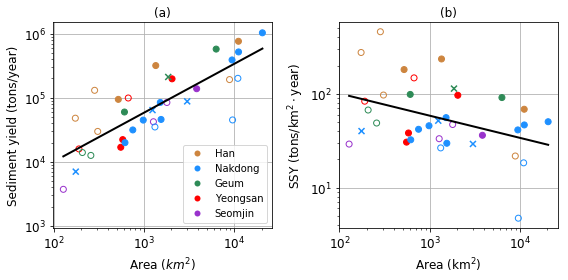

In [24]:
df = cal_sediment_yield().join(src_coefficient().drop("Area", axis=1))

x = df["Area"]
y1 = df["SD"]
y2 = df.SY

m1 = trainLinear(x, y1)
m2 = trainLinear(x, y2)


good_data = df[(df['Rsquared'] > 0.7) & (df['nyear'] > 2)]
short_data = df[(df['nyear'] <= 2) & (df['Rsquared'] > 0.7)]
poor_r = df[df['Rsquared'] <= 0.7]



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))


ax1.scatter(good_data.Area, good_data.SY, color=[colors[x] for x in good_data.index.str[0]])
ax1.scatter(short_data.Area, short_data.SY,
           facecolor='none', edgecolors=[colors[x] for x in short_data.index.str[0]])
ax1.scatter(poor_r.Area, poor_r.SY, marker='x', color=[colors[x] for x in poor_r.index.str[0]])

ax1.plot(x, np.e**m2.fittedvalues, 'k-', lw=2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Sediment yield (tons/year)')
ax1.set_xlabel('Area ($km^2$)')

ax1.set_title("(a)")
ax1.set_ylim((942.80883925637954, 1496270.0746760515))


# area vs sediment yield (tons/sqkm/year)
ax2.scatter(good_data.Area, good_data.SD, color=[colors[x] for x in good_data.index.str[0]])
ax2.scatter(short_data.Area, short_data.SD,
           facecolor='none', edgecolors=[colors[x] for x in short_data.index.str[0]])
ax2.scatter(poor_r.Area, poor_r.SD, marker='x', color=[colors[x] for x in poor_r.index.str[0]])

# 95% confidence intervals
ax2.plot(x, np.e**m1.fittedvalues, 'k-', lw=2)

ax2.set(xscale='log', yscale='log', xlabel=r"Area (km$^2$)", ylabel="SSY (tons/km$^2\cdot$year)",
       title="(b)", ylim=(3.75, 579.14), xlim=(99.12, 26264.6))


# legend: color of watershed
han = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["H"], label='Han')
nakdong = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["N"], label='Nakdong')
geum = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["G"], label='Geum')
yeongsan = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["Y"], label='Yeongsan')
seomjin = mlines.Line2D([], [], color='none', marker='o', markerfacecolor=colors["S"], label='Seomjin')
handles = [han,nakdong, geum, yeongsan, seomjin]
labels = [h.get_label() for h in handles]
ax1.legend(handles=handles, labels=labels, numpoints=1, loc='lower right')


fig.tight_layout()
ax2.grid()
ax1.grid()
#fig.savefig("Area_SD.pdf", format="pdf", dpi=300, bbox_inches='tight')

In [25]:
def QsCDF(dailyQ, SRC, ascending=True):
    dailyQ = dailyQ.dropna(subset=['Q'])
    dailyQ = dailyQ[dailyQ['Q'] >= 0]
    dailyQ['P'] = dailyQ['Q'].rank(ascending=False,method='min')/(dailyQ.date.count()+1) * 100.0
    a = np.e**SRC.params[0]
    b = SRC.params[1]
    dailyQ["Qs"] = a * dailyQ["Q"]**b / 1000 * 86400 # metric tons/day
    if ascending == True:
        dailyQ = dailyQ.sort_values("Qs")
    else:
        dailyQ = dailyQ.sort_values("Qs", ascending=False)
    dailyQ["cum"] = dailyQ.Qs.cumsum()/dailyQ.Qs.sum()
    return dailyQ

In [26]:
for basin in [small_watershed, large_watershed, rest]:
    dum = list(set(basin).intersection(['N10', 'N13', 'G3', 'N8']))
    for item in dum:
        basin.drop(item)



In [27]:
bapad = plt.rcParams['legend.borderaxespad']
fontsize = plt.rcParams['font.size']
axline = plt.rcParams['axes.linewidth']  #need this, otherwise the result will be off by a few pixels
pad_points = bapad*fontsize + axline  #padding is defined in relative to font size
pad_inches = pad_points/72.0  #convert from points to inches
pad_pixels = pad_inches*fig.dpi  #convert from inches to pixels using the figure's dpi

In [28]:
# Define inverse transform, transforms display coordinates (pixels) to axes coordinates
inv = ax.transAxes.inverted()
# Inverse transform two points on the display and find the relative distance
pad_axes = inv.transform((pad_pixels, 0)) - inv.transform((0,0))  
pad_xaxis = pad_axes[0]

# Find how may pixels there are on the x-axis
x_pixels = ax.transAxes.transform((1,0)) - ax.transAxes.transform((0,0))
# Compute the ratio between the pixel offset and the total amount of pixels 
pad_xaxis = pad_pixels/x_pixels[0]

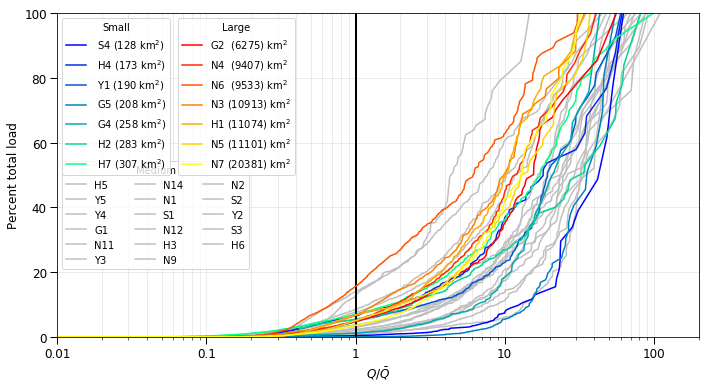

In [29]:
fig, ax = plt.subplots(figsize=(10,5.5))
try:
    rest = rest.drop(['N13', 'G3', 'N8'])
    small_watershed = small_watershed.drop("N10")
except:
    pass
#station_below_dam = ["H3", "H6", "N8", "N13", "Y5", "S1", "S2", "S3"]
for station in rest:
    df = stations[station]["dailyQ"]
    model = stations[station]["src"]
    fdc = stations[station]['fdc']
    Qins = np.interp(1, fdc.P, fdc.Q)
    cdf = QsCDF(df, model)
    ax.plot(cdf.Q/fdc.Q.mean(), cdf.cum * 100, color='0.75',label=station)

    

color_idx = np.linspace(0, 1, len(small_watershed))
for i, station in zip(color_idx, small_watershed):
    df = stations[station]["dailyQ"]
    model = stations[station]["src"]
    fdc = stations[station]['fdc']
    Qins = np.interp(1, fdc.P, fdc.Q)
    l = stations[station]["measureC"].shape[0]
    cdf = QsCDF(df, model)        
    ax.plot(cdf.Q/fdc.Q.mean(), cdf.cum * 100, color=plt.cm.winter(i),label='{:>3s} ({:>3} km$^2$)'.format(station, str(int(round(attribute.loc[station, 'Area'])))))
    ax.set_xscale('log')
    ax.axvline(1, color='k')
    ax.set_ylim([0,100])
    ax.set_xlim(xmin=0.01, xmax=200)
    ax.set_xscale('log')
        #ax.grid(which='both')
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
    ax.tick_params(axis='both', length=7, width=1)
    ax.tick_params(axis='x', length=3, which="minor")
    ax.grid(which='both', color="0.9", linestyle='-')
    ax.set_axisbelow(True)
    ax.set_xlabel(r"$Q/\bar{Q}$")
    ax.set_ylabel("Percent total load")


color_idx = np.linspace(0, 1, len(large_watershed))
for i, station in zip(color_idx, large_watershed):
    df = stations[station]["dailyQ"]
    model = stations[station]["src"]
    fdc = stations[station]['fdc']
    Qins = np.interp(1, fdc.P, fdc.Q)
    l = stations[station]["measureC"].shape[0]
    cdf = QsCDF(df, model)        
    ax.plot(cdf.Q/fdc.Q.mean(), cdf.cum * 100, color=plt.cm.autumn(i),label='{:>2s} {:>7} km$^2$'.format(station, '(' + str(int(round(attribute.loc[station, 'Area']))) + ')'))

handles, labels = ax.get_legend_handles_labels()

fig.canvas.draw()
axbox = ax.get_position()
legend = fig.legend(handles[:len(rest)], labels[:len(rest)],loc=2, bbox_to_anchor=(0,0.56),
                    bbox_transform=ax.transAxes, title='Medium', ncol=3)
legend_width = legend.get_window_extent().inverse_transformed(ax.transAxes).width


fig.legend(handles[len(rest):len(rest)+len(small_watershed)], labels[len(rest):len(rest)+len(small_watershed)],
           loc=2, bbox_to_anchor=(0,1), bbox_transform=ax.transAxes, title='Small')

fig.legend(handles[len(rest)+len(small_watershed):], labels[len(rest)+len(small_watershed):],
           loc=2, bbox_to_anchor=(0.18,1), bbox_transform=ax.transAxes, title='Large')



#ax.annotate("Small", xy=(0.24, 0.95),  xycoords="axes fraction", fontsize='large')
#ax.annotate("Medium", xy=(0.08, 0.95),  xycoords="axes fraction", fontsize='large')
#ax.annotate("Large", xy=(0.335, 0.95),  xycoords="axes fraction", fontsize='large')  

#ax.annotate("H6", xy=(4, 0.5), xytext=(2.5, 0.5), arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3"),horizontalalignment='right', 
#            verticalalignment='bottom', fontsize='large')

fig.tight_layout()
#fig.savefig("csy.pdf", format="pdf", dpi=300, bbox_inches='tight')


0.2639919876723985
0.4831089442786908
0.6038775480776676
0.1308672802958548
0.4809304658625677
0.30217397161890797
1.0032911054161093


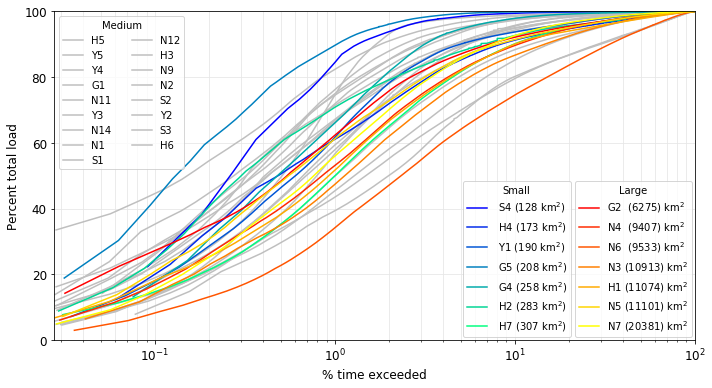

In [30]:
fig, ax = plt.subplots(figsize=(10,5.5))


#station_below_dam = ["H3", "H6", "N8", "N13", "Y5", "S1", "S2", "S3"]
for station in rest:
    df = stations[station]["dailyQ"]
    model = stations[station]["src"]
    fdc = stations[station]['fdc']
    Qins = np.interp(1, fdc.P, fdc.Q)
#    l = stations[station]["measureC"].shape[0]
    cdf = QsCDF(df, model,ascending=False)        
    ax.plot(cdf.P, cdf.cum * 100, color='0.75',label=station)

color_idx = np.linspace(0, 1, len(small_watershed))
for i, station in zip(color_idx, small_watershed):
    df = stations[station]["dailyQ"]
    model = stations[station]["src"]
    fdc = stations[station]['fdc']
    Qins = np.interp(1, fdc.P, fdc.Q)
    l = stations[station]["measureC"].shape[0]
    cdf = QsCDF(df, model,ascending=False)        
    ax.plot(cdf.P, cdf.cum * 100, color=plt.cm.winter(i),label='{:>3s} ({:>3} km$^2$)'.format(station,
            str(int(round(attribute.loc[station, 'Area'])))))

    
    a = np.interp(0.5, cdf.cum, cdf.P)
    print(a)
    ax.set_ylim([10, 100])
    ax.grid(which='both', color="0.9", linestyle='-')
    ax.set_axisbelow(True)
    ax.set_xlabel("% time exceeded")
    ax.set_ylabel("Percent total load")


color_idx = np.linspace(0, 1, len(large_watershed))
for i, station in zip(color_idx, large_watershed):
    df = stations[station]["dailyQ"]
    model = stations[station]["src"]
    fdc = stations[station]['fdc']
    cdf = QsCDF(df, model, ascending=False)

    ax.plot(cdf.P, cdf.cum * 100, color=plt.cm.autumn(i),label='{:>2s} {:>7} km$^2$'.format(station,
                '(' + str(int(round(attribute.loc[station, 'Area']))) + ')'))

    

handles, labels = ax.get_legend_handles_labels()

fig.canvas.draw()
axbox = ax.get_position()
legend = fig.legend(handles[:len(rest)], labels[:len(rest)],loc=2, bbox_to_anchor=(0.001,1),
                    bbox_transform=ax.transAxes, title='Medium', ncol=2)
legend_width = legend.get_window_extent().inverse_transformed(ax.transAxes).width


fig.legend(handles[len(rest):len(rest)+len(small_watershed)], labels[len(rest):len(rest)+len(small_watershed)],
           loc=2, bbox_to_anchor=(0.63,0.5), bbox_transform=ax.transAxes, title='Small')

fig.legend(handles[len(rest)+len(small_watershed):], labels[len(rest)+len(small_watershed):],
           loc=2, bbox_to_anchor=(0.805,0.5), bbox_transform=ax.transAxes, title='Large')    
    
ax.set_xscale('log')
ax.set_ylim([0, 100])
ax.margins(x=0)
#ax.set_xticks(range(1, 100, 11))
fig.tight_layout()
#fig.savefig("csy_.pdf", format="pdf", dpi=300)

In [31]:
Qs_list = {}

for site in stations.keys():
    if site not in ['N10', 'N13', 'G3', 'N8']:
        df = stations[site]["dailyQ"]
        model = stations[site]["src"]
        fdc = stations[site]['fdc']
        
        Qmean = fdc.Q.mean()
        
        cdf = QsCDF(df, model)     
        cdf['Q/Qbar'] = cdf['Q'] / Qmean
        Qs_target = np.interp([0.25, 0.5, 0.75], cdf['cum'], cdf['Q/Qbar'])
        Qs_list[site] = Qs_target
        
Qs_list = pd.DataFrame(Qs_list).T
Qs_list.columns = ["Q1", "Q2", "Q3"]
Qs_list = Qs_list.join(src_coefficient().drop("Area", axis=1))

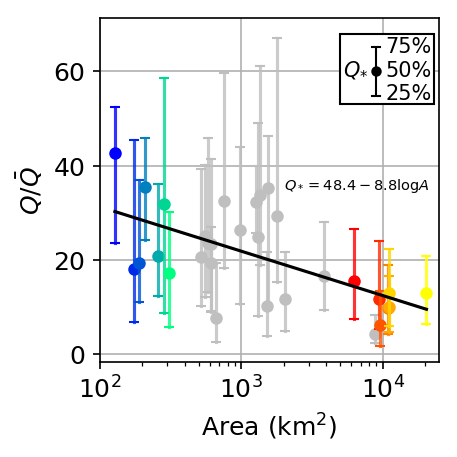

In [38]:
fig, ax = plt.subplots(figsize=(3.15,3.15), dpi=150)

#df = df.drop(["N13", "H6"])

_df = attribute.join(Qs_list)
for station in rest:
    df = stations[station]["dailyQ"]
    model = stations[station]["src"]
    fdc = stations[station]['fdc']
    Qins = np.interp(1, fdc.P, fdc.Q)
    cdf = QsCDF(df, model)

    ax.plot([_df.loc[station, 'Area'], _df.loc[station, 'Area']],  [_df.loc[station, 'Q1'],_df.loc[station, 'Q3']], '-', color='0.75', ms=8, alpha=0.8)
    ax.plot(_df.loc[station, 'Area'], _df.loc[station,'Q2'], 'o', color='0.75', ms=5)
    ax.plot(_df.loc[station, 'Area'], _df.loc[station,'Q1'], '_', color='0.75', ms=5)
    ax.plot(_df.loc[station, 'Area'], _df.loc[station,'Q3'], '_', color='0.75', ms=5)

color_idx = np.linspace(0, 1, len(small_watershed))
for i, station in zip(color_idx, small_watershed):
    df = stations[station]["dailyQ"]
    model = stations[station]["src"]
    fdc = stations[station]['fdc']
    Qins = np.interp(1, fdc.P, fdc.Q)
    l = stations[station]["measureC"].shape[0]
    cdf = QsCDF(df, model)        

    ax.plot([_df.loc[station, 'Area'], _df.loc[station, 'Area']],  [_df.loc[station, 'Q1'],_df.loc[station, 'Q3']], '-', color=plt.cm.winter(i), ms=8, alpha=0.8)
    ax.plot(_df.loc[station, 'Area'], _df.loc[station,'Q2'], 'o', color=plt.cm.winter(i), ms=5)
    ax.plot(_df.loc[station, 'Area'], _df.loc[station,'Q1'], '_', color=plt.cm.winter(i), ms=5)
    ax.plot(_df.loc[station, 'Area'], _df.loc[station,'Q3'], '_', color=plt.cm.winter(i), ms=5)


color_idx = np.linspace(0, 1, len(large_watershed))
for i, station in zip(color_idx, large_watershed):
    df = stations[station]["dailyQ"]
    model = stations[station]["src"]
    fdc = stations[station]['fdc']
    Qins = np.interp(1, fdc.P, fdc.Q)
    l = stations[station]["measureC"].shape[0]
    cdf = QsCDF(df, model)        

    ax.plot([_df.loc[station, 'Area'], _df.loc[station, 'Area']],  [_df.loc[station, 'Q1'],_df.loc[station, 'Q3']], '-', color=plt.cm.autumn(i), ms=8, alpha=0.8)
    ax.plot(_df.loc[station, 'Area'], _df.loc[station,'Q2'], 'o', color=plt.cm.autumn(i), ms=5)
    ax.plot(_df.loc[station, 'Area'], _df.loc[station,'Q1'], '_', color=plt.cm.autumn(i), ms=5)
    ax.plot(_df.loc[station, 'Area'], _df.loc[station,'Q3'], '_', color=plt.cm.autumn(i), ms=5)  


ax.set_xlim(xmin=100, xmax=25000)
ax.set(xscale='log', xlabel='Area (km$^2$)', ylabel=r'$Q/\bar{Q}$')
ax.grid()

_df = _df.dropna().sort_values(by="Area")
x = _df.dropna().Area
y = np.e**_df.dropna().Q2
regression = trainLinear(x, y)
coef1, coef2 = np.e**regression.params[0], regression.params[1]
ax.plot(x, np.log(coef1*x**coef2), 'k-', label='_nolegend_')

ax.add_patch(
    patches.Rectangle(
        (5000, 53),   # (x,y)
        18000,          # width
        15,          # height
        facecolor='white',
        edgecolor='k'
    )
)

ax.add_line(lines.Line2D(((9000, 9000)), ((55,65)), linewidth=1, color='k'))
ax.add_line(lines.Line2D(((8350, 9590)), ((65.2,65.2)), linewidth=1, color='k'))
ax.add_line(lines.Line2D(((8350, 9590)), ((54.8,54.8)), linewidth=1, color='k'))
ax.plot((9000), (60), 'ko', ms=4)
ax.annotate('75%', xy=(10500,64))
ax.annotate('50%', xy=(10500,59))
ax.annotate('25%', xy=(10500,54))
ax.annotate('$Q_{*}$', xy=(5200, 59))
ax.annotate('$Q_*=48.4-8.8\logA$', (2000,35), fontsize=7)


ax.set_axisbelow(True)
fig.tight_layout()
